# Affects in Tweets - Twitter Sentiment Analysis

- André Rocha, FEUP, up201706462@fe.up.pt
- Tito Griné, FEUP, up201706732@fe.up.pt
- Vítor Ventuzelos, FEUP, up201706403@fe.up.pt

## Abstract
In recent years, Sentiment Analysis has become a sought after tool by businesses and organizations to measure the public's opinion on a given subject or product. One of the most explored source of textual data has become Twitter, more specifically tweets. Given their short nature, with a limit of 140 characters, they force the writer to express their thoughts in a concise way, resorting to word contractions, slang and most notably emojis. This poses a complicated challenge when attempting to analyse them, but doing so effectively allows access to a lot of meaningful information as a large portion of the world uses Twitter as their primary means of communicating with large audiences and adquiring news,  therefore making it worth exploring. In this paper, we attempted to do just that, a model capable of rating tweets as negative, neutral or positive as accurately as possible. Using the SemEval 2018 dataset for sentiment analysis, we tested various popular classifiers, and various pre-processing methods to reduce noise, in an attempt to determine a combination that would achieve the best results.

## Introduction
Twitter sentiment analysis has become a common method to monitor the public's opinion regarding a given matter (either their brand, business, etc). It is known such an analysis has very noticeable differences towards other sentiment analysis challenges: Twitter's messages, usually called Tweets, have a very noisy nature. Starting off the fact that it only allows 140 characters, which leads to several abbreviations and irregular expressions, it is also a space where slang is very common. These cases lead to a very high level of data sparsity.

Having to face such an issue, it is common to resort to stopwords to reduce textual noise. Due to its irregular contractions and slang, using pre-compiled stopwords lists have a negative impact, due to their inabilities to keep to up to date with new terms and information. It has been shown though, that dynamically generated stopwords lists increase accuracies greatly (Saif et.al 2014).

It is also common for emojis to be used in tweets. Standard approaches include removing them as a whole, attribute a sentiment to it or express it by a single word.

There also recognizable noise patterns which appear frequently that are commonly removed from a tweet such as: hashtags ('#'), URLs, and repeated letters. These usually tend to have a negative impact by themselves, given that they convey little meaning in regards to sentiment.

Due to the common use of slang, contractions and even the misspelling of words, the substitution of these by their more formal/correct version is usually explored, once again to further reduce data sparsity.

All of the methods explained above, and some other common approaches to NLP problems such as lemmatization and stemming, will be explored. A simple baseline method using only a Tokenizer will be used to compare against the others. Furthermore, several different Classifiers will be explored, such as [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), [Support Vector Machines](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm), [Multi-layer Perceptron Neural Network](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) and [1D Convolutional Neural Network](https://keras.io/examples/imdb_cnn/).

In [4]:
from datasets.process_dataset import process_dataset
data1 = process_dataset("datasets/trains.txt")
data2 = process_dataset("datasets/dev.txt")
data3 = process_dataset("datasets/test.txt")
data = data1 + data2 + data3

## Dataset Analysis
Firstly an analysis was made of the quality of the SemEval2018 challenge dataset. This was relevant to understand some of its shortcomings, such as the fact that the dataset is very small or that the class distribution is not particularly even.

### Class Distribution
We started by performing a class distribution analysis, in order to perceive how balanced our sample was. It is clear to see that the distribution is quite uneven between all of the classes, which created a new need: to test the use of oversampling, which will be discussed later. Something that also stands out is the fact that the number of samples of this dataset is quite small, which led us to believe solutions based on Word Embeddings (such as our Convolutional Neural Network) would have poor results.

Such findings led us to baseline results which would be much lower than expected, especially when it came to such a classification using such a small dataset. It also led us to considered the reduction of the number of labels. Most works seen in this area had indeed resorted mostly to binary classification (in positive or negative) or to tertiary classification (either positive, negative or neutral).


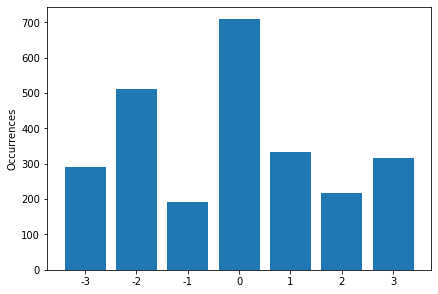

In [5]:
import numpy as np
import matplotlib.pyplot as plt

classes = {}
for t in data:
    classes[t.intensity] =  classes.get(t.intensity, 0) + 1

objects = sorted(classes.keys())
y_pos = np.arange(len(objects))
values = list(map(lambda key: classes[key], objects))

plt.bar(y_pos, values)
plt.xticks(y_pos, objects)
plt.ylabel('Occurrences')
plt.tight_layout(0.4)
plt.savefig('intensity_analysis.png')
plt.show()

### TF-IDF Distribution

It was then decided to assert the quality of the Tweets in the dataset. With the TF-IDF distribution, we are able to assert the amount of times words are repeated throughout the dataset. This information is shown below using a Scatter Plot.

From the amount of words whose TF-IDF is near zero, it is clear that most words do not show up more than once in the whole dataset. This gave us the knowledge that most information would be removed from Tweets if we were to use the dynamic stopwords list generation method TF1, whose goal is to remove all words who only show up once in the whole dataset.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = map(lambda x: x.tweet, data)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(corpus)

tfidf_mean = tfidf_vectorizer_vectors.mean(axis=0).tolist()[0]

# get the first vector out (for the first document)

# place tf-idf values in a pandas data frame
plt.figure(figsize=(10,4))
plt.scatter(tfidf_vectorizer.get_feature_names(), tfidf_mean, s=5)
plt.ylabel('TF-IDF Value')
plt.gca().axes.xaxis.set_visible(False)
plt.savefig('tf_idf.png')
plt.show()

### Wordcloud
Even though a wordcloud does not represent any new information regarding what has been shown before, it is an interesting way to look at the words existing in the dataset. It also allowed us to visualize how common the use of the ampersand was, which made us understand that it was vital to remove some HTML references that were still in the dataset.

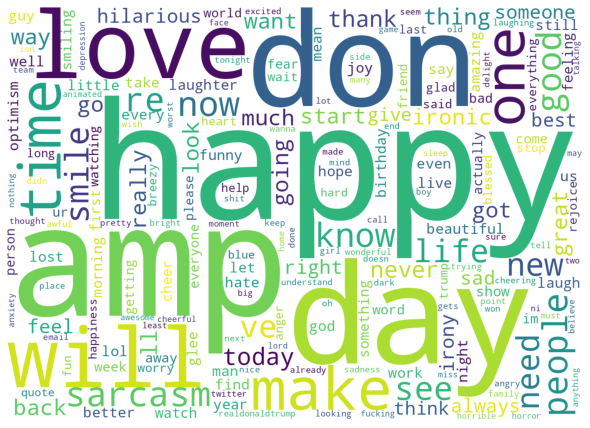

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

corpus = map(lambda x: x.tweet, data)
count_vectorizer = CountVectorizer()
count_vectorizer_vectors = count_vectorizer.fit_transform(corpus)
word_count = count_vectorizer_vectors.sum(axis=0).tolist()[0]

features = count_vectorizer.get_feature_names()
cloud_words = ""
for i in range(0, len(word_count)):
    for _ in range(0, word_count[i]):
        cloud_words += features[i] + " "

wordcloud = WordCloud(width=1280, height=920, background_color='white', stopwords=STOPWORDS, collocations=False).generate(cloud_words)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png')
plt.show()

## Approach Analysis
In this section, all the parameters existing throughout the training process will be analyzed. It will specifically focus on these sections:

- Dataset unevenness analysis - analysis on how the label unevenness will affect the quality of the results.
- Classifier quality analysis - analysis on different classifiers, in order to detect the best one for this problem.
- Pre-processing analysis - analysis on the inclusion of several different steps to the pipeline


### Dataset Unevenness
During the dataset analysis it had been shown, how considerable the difference was between the labels in the dataset. In this section, it will be shown that impact, by reducing the number of labels.

The original dataset had the label range of [-3, -3] being the most negative possible label and 3 the most positive label. This will be tested against the range of [0, 2] (i.e. if a tweet is negative, neutral or positive), and with the range of 0, 1 (i.e. if a tweet is positive or not).

For this test, a very simple pre-processing will be done: tweet Tokenization, followed by a TF-IDF Vectorization and then classifcation. A Multinomial Naive Bayes classifier will be used for their classification, due to its simplicity and relatively good results in most NLP problems.

In [5]:
from pipelines.basic import basic_pipeline
from datasets.process_dataset import get_dataset
from sklearn.naive_bayes import MultinomialNB
from datasets.process_dataset import process_valence_for_2, process_valence_for_3


x, y = get_dataset(data)
y_3 = list(map(lambda valence: process_valence_for_3(valence), y))
y_2 = list(map(lambda valence: process_valence_for_2(valence), y))

clsf = MultinomialNB()
clsf_3 = MultinomialNB()
clsf_2 = MultinomialNB()
y_test, y_pred, y_time  = basic_pipeline(x, y, clsf)
y_test_3, y_pred_3, y_time_3  = basic_pipeline(x, y_3, clsf)
y_test_2, y_pred_2, y_time_2  = basic_pipeline(x, y_2, clsf)


Using TensorFlow backend.


              precision    recall  f1-score   support

          -3       0.39      0.49      0.44        63
          -2       0.35      0.33      0.34        88
          -1       0.12      0.25      0.17        36
           0       0.49      0.22      0.30       159
           1       0.17      0.16      0.17        61
           2       0.17      0.25      0.20        48
           3       0.32      0.42      0.36        59

    accuracy                           0.29       514
   macro avg       0.29      0.30      0.28       514
weighted avg       0.34      0.29      0.30       514

              precision    recall  f1-score   support

           0       0.67      0.57      0.61       202
           1       0.41      0.50      0.45       141
           2       0.67      0.67      0.67       171

    accuracy                           0.58       514
   macro avg       0.58      0.58      0.58       514
weighted avg       0.60      0.58      0.59       514

              precisio


With the result of this graphic, it is possible to observe the effect of reducing the number of labels. It's also fair to assume it would be better to reduce the number of labels to **three** due to the outstanding increase in all scores, and the better compromise (since two labels was considered to be more lacking in terms on the knowledge that came out of the model). Therefore, it is important to refer how all results from this point forward **will be presented with 3 labels instead of the original 7**.

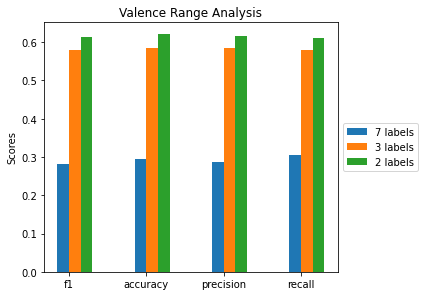

In [6]:
from scoring import build_comparison_graph, get_scores
score = get_scores(y_test, y_pred)
score_3 = get_scores(y_test_3, y_pred_3)
score_2 = get_scores(y_test_2, y_pred_2)

build_comparison_graph(["f1", "accuracy", "precision", "recall"], [score, score_3, score_2], ["7 labels", "3 labels", "2 labels"], 0.15, "Valence Range Analysis")

### Classifier Quality
In order to better understand which one classifier is best, the performance from several different classifiers will be compared, in order to better understand which one is able to have better results for our solution.

It is important to notice that all of these classifiers have suffered hyperparameter optimization beforehand in order to bring out the best results possible from them and reduce the number of comparisons brought to the table. Furthermore, tests will be done in the same pipeline used in unevenness analysis.

Based on that, the chosen classifiers and their respective parameters are the following:

- Multinomial Naive Bayes - with alpha (additive smoothing parameter) of 1.0
- Support Vector Classifier - with a linear kernel, using a shrinking heuristic
- Linear Support Vector Classifier - with the hinge loss function (the one used in the Support Vector Classifier)
- Multi-layer Perceptron - With relu as its activation function, lbfgs as the weight optimization solver (due to its capacity with smaller datasets).
- 1D Convolutional Neural Network - network with an initial embedding layer, followed by a dropout with a rate of 0.42, followed by a 1D convolutional layer with 500 filters and a kernel size of 3, and relu as its activation function. It is then followed by a Global Max Pooling and two Dense layers: one with 500 units and the ending layer with the number of outputs. It uses adam as its weight optimization solver.

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       195
           1       0.40      0.42      0.41       144
           2       0.67      0.69      0.68       175

    accuracy                           0.60       514
   macro avg       0.58      0.58      0.58       514
weighted avg       0.60      0.60      0.60       514

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       206
           1       0.38      0.35      0.36       143
           2       0.65      0.65      0.65       165

    accuracy                           0.57       514
   macro avg       0.55      0.56      0.56       514
weighted avg       0.57      0.57      0.57       514

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       209
           1       0.45      0.36      0.40       149
           2       0.63      0.68      0.65       156

    accuracy        

/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


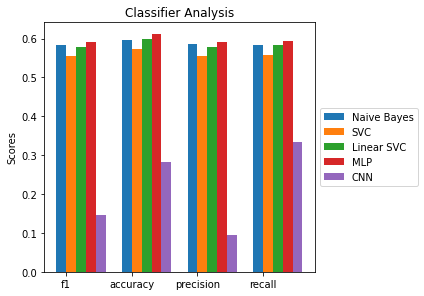

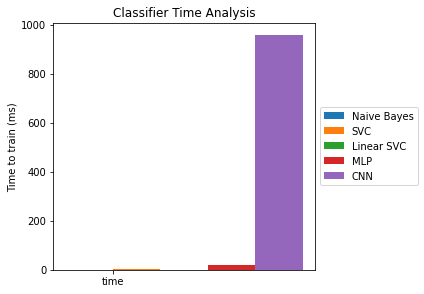

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from classifiers.cnn import CNN
from pipelines.basic import basic_pipeline


naive = MultinomialNB()
svc = SVC(kernel='linear')
linear_svc = LinearSVC(loss='hinge')
nn = MLPClassifier(solver='lbfgs')
cnn = CNN(dropout_rate=0.42, filters=500, units=500, epochs=4)

naive_test, naive_pred, naive_time = basic_pipeline(x, y_3, naive)
svc_test, svc_pred, svc_time = basic_pipeline(x, y_3, svc)
linear_svc_test, linear_svc_pred, linear_svc_time = basic_pipeline(x, y_3, linear_svc)
nn_test, nn_pred, nn_time = basic_pipeline(x, y_3, nn)
cnn_test, cnn_pred, cnn_time = basic_pipeline(x, y_3, cnn)

naive_scores = get_scores(naive_test, naive_pred)

svc_scores = get_scores(svc_test, svc_pred)

linear_svc_scores = get_scores(linear_svc_test, linear_svc_pred)

nn_scores = get_scores(nn_test, nn_pred)

cnn_scores = get_scores(cnn_test, cnn_pred)


build_comparison_graph(["f1", "accuracy", "precision", "recall"], [naive_scores,svc_scores,linear_svc_scores,nn_scores,cnn_scores], ["Naive Bayes", "SVC", "Linear SVC", "MLP", "CNN"], 0.15, "Classifier Analysis")

build_comparison_graph(["time"], [[naive_time], [svc_time],[linear_svc_time], [nn_time], [cnn_time] ],["Naive Bayes", "SVC", "Linear SVC", "MLP", "CNN"], 0.3, "Classifier Time Analysis", y_label="Time to train (ms)")

From the shown results, it it clear how much the first 4 classifiers are close to each other, with naive bayes having a slightly better accuracy surprisingly.

It is to no surprise that the convolutional neural network has weak results compared to the other classifiers, due to the size of the dataset, which does not assure enough data to properly train it. This proves that there would be interest in testing further data generation and augmentation techniques, in order to obtain an even bigger dataset.

Given these results, it is safe to assume that the use of Naive Bayes for the rest of the analysis will bring out the best results, since it is the most simple classifier as well as the one who tends to be more susceptible to pre-processing.

### Pre-processors Analysis
In this section, the same analysis as the previous ones will be done, but for pre-processors. For this analysis, several different combinations of pre-processors were chosen, such as:

- Basic Pipeline - the same pipeline used in all of the other tests beforehand. It uses a Tokenizer specialized for Twitter from the nltk library, where handles are removed and it is aware of emoticons. It is followed by a TF-IDF Vectorization and the classification it self.

- Emojis Pipeline - adds a new step to the Basic Pipeline before vectorization, where all emojis and emoticons are converted to words best signifying their meaning.

- Simple Pipeline - adds a new step to the Basic Pipeline before vectorization, which performs lemmatization using the WordNetLemmatizer from the nltk library.

- Stemming Pipeline - a similar pipeline to the Simple Pipeline presented beforehand, that instead of lemmatization uses a stemming algorithm called "snowball", conceived to be an improved version of the famous Porter algorithm.

- Stopwords Pipeline - adds a new step to the Simple Pipeline after Tokenization, where all singleton words are removed from the dataset. Using the Counter class to assign each word its frequency, and then removing all tokens with a frequency of one.

- Everything Pipeline - as the name implies, this pipeline takes almost all created processors. After Tokenization, and removal of stopwords, the miscellaneous processor is applied. In short, it applies different small processing technique, such as removing single letter words, numbers, URLs, punctuation, hashtags and finally converting words which are safe to remove capital letters, that is, where only the first letter is capitalized. This is followed by an expansion of common word contraction by using a dictionary taken from (insert link), where popular contractions are associated with their formal forms, the processor replaces tokens that match these contractions. Then, using the symspellpy library, possible misspellings are corrected. This is followed by the emojis processor (same as the Emojis Pipeline). Finally, before vectorization is done, lemmatization is performed much like the Simple Pipeline.

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       209
           1       0.39      0.46      0.42       127
           2       0.70      0.70      0.70       178

    accuracy                           0.62       514
   macro avg       0.61      0.61      0.61       514
weighted avg       0.64      0.62      0.63       514

              precision    recall  f1-score   support

           0       0.68      0.58      0.63       194
           1       0.37      0.44      0.40       141
           2       0.66      0.66      0.66       179

    accuracy                           0.57       514
   macro avg       0.57      0.56      0.56       514
weighted avg       0.59      0.57      0.58       514

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       202
           1       0.43      0.48      0.45       156
           2       0.69      0.70      0.69       156

    accuracy        

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/andrefmrocha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/andrefmrocha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


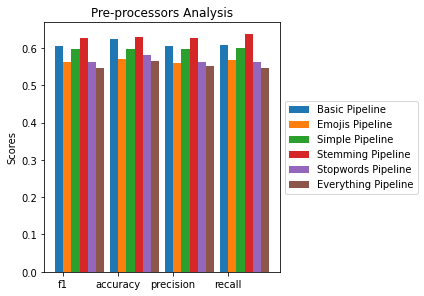

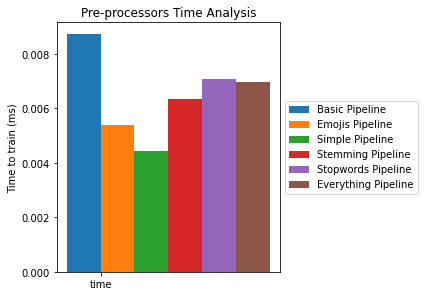

In [8]:
from pipelines.basic import basic_pipeline
from pipelines.simple_preprocessors import simple_pipeline
from pipelines.everything import everything_pipeline
from pipelines.stopwords import stopwords_pipeline
from pipelines.emojis import emojis_pipeline
from pipelines.stemming_pipeline import stemming_pipeline
from scoring import get_scores, build_comparison_graph

basic_pred, basic_test, basic_time = basic_pipeline(x, y_3, MultinomialNB())

emojis_pred, emojis_test, emojis_time = emojis_pipeline(x, y_3, MultinomialNB())

simple_pred, simple_test, simple_time = simple_pipeline(x, y_3, MultinomialNB())

stemming_pred, stemming_test, stemming_time = stemming_pipeline(x, y_3, MultinomialNB())

stopwords_pred, stopwords_test, stopwords_time = stopwords_pipeline(x, y_3, MultinomialNB())

everything_pred, everything_test, everything_time = everything_pipeline(x, y_3, MultinomialNB())

basic_scores = get_scores(basic_test, basic_pred)
emojis_scores = get_scores(emojis_test, emojis_pred)
simple_scores = get_scores(simple_test, simple_pred)
stemming_scores = get_scores(stemming_test, stemming_pred)
stopwords_scores = get_scores(stopwords_test, stopwords_pred)
everything_scores = get_scores(everything_test, everything_pred)

build_comparison_graph(["f1", "accuracy", "precision", "recall"], [basic_scores,emojis_scores,simple_scores,stemming_scores,stopwords_scores, everything_scores], ["Basic Pipeline", "Emojis Pipeline", "Simple Pipeline", "Stemming Pipeline", "Stopwords Pipeline", "Everything Pipeline"], 0.15, "Pre-processors Analysis")

build_comparison_graph(["time"], [[basic_time], [emojis_time],[simple_time], [stemming_time], [stopwords_time], [everything_time] ],["Basic Pipeline", "Emojis Pipeline", "Simple Pipeline", "Stemming Pipeline", "Stopwords Pipeline", "Everything Pipeline"], 0.3, "Pre-processors Time Analysis", y_label="Time to train (ms)")

Looking at the first graph, it is clear that the difference in precision throughout the pipelines is mostly negligible. This leads us to infer how certain pre-processors have little impact on the the different metrics being used, leading us to believe their impact for this problem is barely relevant.

On the other hand, there is a significant impact when it comes to the time spent on training. A reduction is clearly portrayed, of all pipelines compared to the original one. There's a slight difference (that surely would be much greater if the size of the dataset was more favorable), in both the pipelines using the TF1 Stopwords. The reduction in the number of words is great, something that would have an even higher impact in classifiers such as Support Vector Machines or Neural Networks. This is also accompanied by a slight loss of accuracy, which can be attributed to those words which are lost being derivations of other ones.

## Conclusions

In this paper, we began by looking on how the number of labels affected a preliminary analysis, and concluded based on four classification quality measures, that the use of 7 labels to classify our data greatly hindered our results, and faced with the fact that most tweet sentiment works rely on a binary or tertiary labels, we decided to continue the rest of our analysis using a tertiary classification as it still allows a more clear distinction between tweets than a simple binary one, while maintaining good results.

Following this, our analysis of the classifiers quality showed us that, unexpectedly, Naive Bayes performed slightly better than the rest. We assume this is a result of its simplicity, and perhaps the fact that our dataset may have domains with features similarly important. On the other hand, the convolutional neural network performed the worst, mainly due to the lack of training data, which proved not enough to properly train it.

As the last step, various pre-processors and combinations thereof were tested using the Naive Bayes classifier, in an attempt to discover a particular set that would improve results both in terms of classification metrics and train/test elapsed time. What we found was that, unfortunately, the pre-processing of data decreased all classification metrics used relative to Tokenization alone, with the exception of stemming, which seemed to consistently have a slightly better performance, mostly due to a better capability of detecting positive tweets. Regarding execution time, pre-processing more than halves the processing compared to only tokenizing the tweets. As expected, the one with better results was the removal of stopwords with frequency of one.

With these results, we can conclude that, from what was tested, the best results were obtained by using Naive Bayes as classifier, combining it with a stemming pre-processing that not only slightly improves classification metrics but greatly reduces processing time.

Overall, as with most problems in machine learning, data quantity and quality didn't allow us to take this exploration as far as we would like, namely the fact that exploring convolutional neural networks proved to be difficult. Therefore, in the future, we would aim to try and find other datasets with more data and possibly combine them, or even research better techniques for oversampling, taking in our around two thousand tweets from the dataset and generate more in order to be able to train our model better and explore other classifiers. Another aspect worth mentioning would be to further test more combinations of pre-processors or even create new ones, and test them with various classifiers in order to hopefully discover an optimal combination.


## References
1. A. Kunwar, [Twitter Sentiment Analysis GUI](https://github.com/akbloodadarsh/Twitter-Sentimental-Analysis)
2. C. Alcantara and J. Cassiano, [Social Network Sentiment Analysis](https://github.com/cassio-all/sentimental_analysis_twitter)
3. C. Baziotis, [SemEval 2018](https://github.com/cbaziotis/ntua-slp-semeval2018)
4. S. Doshi, [Twitter Sentiment Analysis using fastText](https://towardsdatascience.com/twitter-sentiment-analysis-using-fasttext-9ccd04465597)
5. Hassan S., Miriam F., Yulan H. and Harith, A,  ["On Stopwords, Filtering and Data Sparsity for Sentiment Analysis of Twitter"](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf), 2014
6. Z. Jianqiang and G. Xiaolin, ["Comparison Research on Text Pre-processing Methods on Twitter Sentiment Analysis"](https://ieeexplore.ieee.org/abstract/document/7862202), 2017
7. A. Severyn and A. Moschitti, ["Twitter Sentiment Analysis with Deep Convolutional Neural Networks"](https://dl.acm.org/doi/abs/10.1145/2766462.2767830), 2015
